<font size=7> Animation for Sury

**Sury Requirements**
* For creating the LFP propatation for recroding 1
* burst_id = 2 # the third burst in the recording
* recording= "Hc112823_avv9hckcr1_21841_120323_1.raw.h5"
* burst_range = [298.719, 300.719] # 2 seconds
* binsize = 0.1 #100 ms

# Setup

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from human_hip.raw_data import get_brain_waves
from human_hip.animate import animate_waves
from human_hip.spike_data import read_autocurated_data, plot_raster


In [2]:
with open("/workspaces/human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1/opto_start223s_stop228s_fs1ms.pkl", 'rb') as filename:
    data_raw = pickle.load(filename)
print(data_raw.keys())
print(data_raw["data"].shape)

dict_keys(['data', 'xy', 'frame_rate', 'uuid', 'file'])
(1009, 5000)


In [3]:
sd = read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_1_acqm.zip" )


In [4]:
opto = np.load( "opto_gpio.npy" )

(<Axes: xlabel='Time (s)', ylabel='Unit'>,
 <Axes: xlabel='Time (ms)', ylabel='Population Firing Rate (Hz)'>)

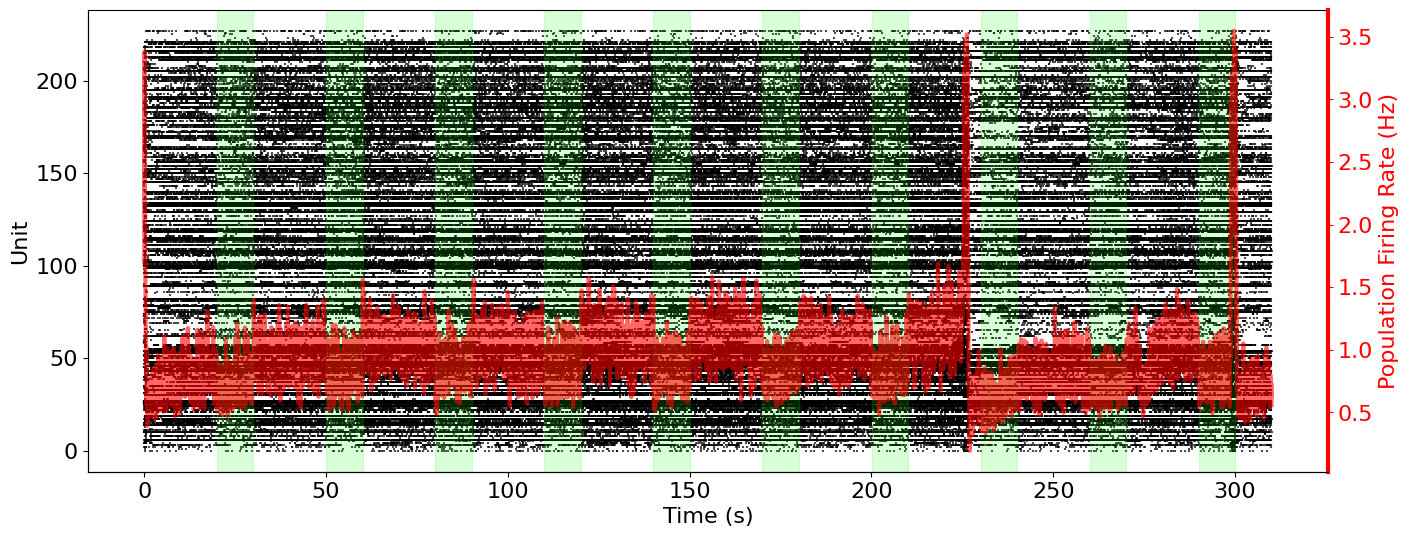

In [5]:
plot_raster( sd, opto=opto)

(<Axes: xlabel='Time (s)', ylabel='Unit'>,
 <Axes: xlabel='Time (ms)', ylabel='Population Firing Rate (Hz)'>)

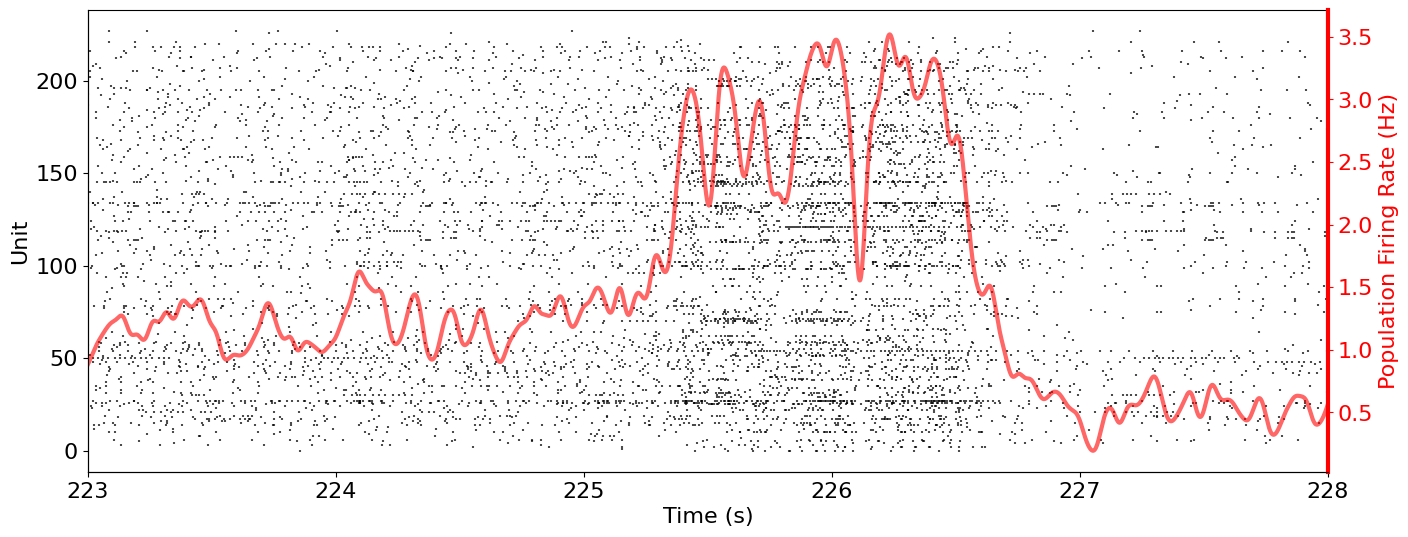

In [6]:
plot_raster( sd, opto=opto,  xlim=(223,228) )

# Make Animation

In [9]:
from human_hip.raw_data import get_brain_waves
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt
from braingeneers.analysis.analysis import SpikeData
from scipy.ndimage import gaussian_filter1d
import numpy as np

In [16]:
raw_dict = data_raw
wave_type="theta"
movie_range_ms= range(2000,4000,5)
filename='./hc112823_opto_theta_raster_start223s_range_2000_4000_5.mp4'
image_path = "/workspaces/human_hippocampus/data/histology/john2.png"

frame_interval_ms=100
size_exp=1.9
size_scale=90
start_s = 223
xlim = (205, 230)

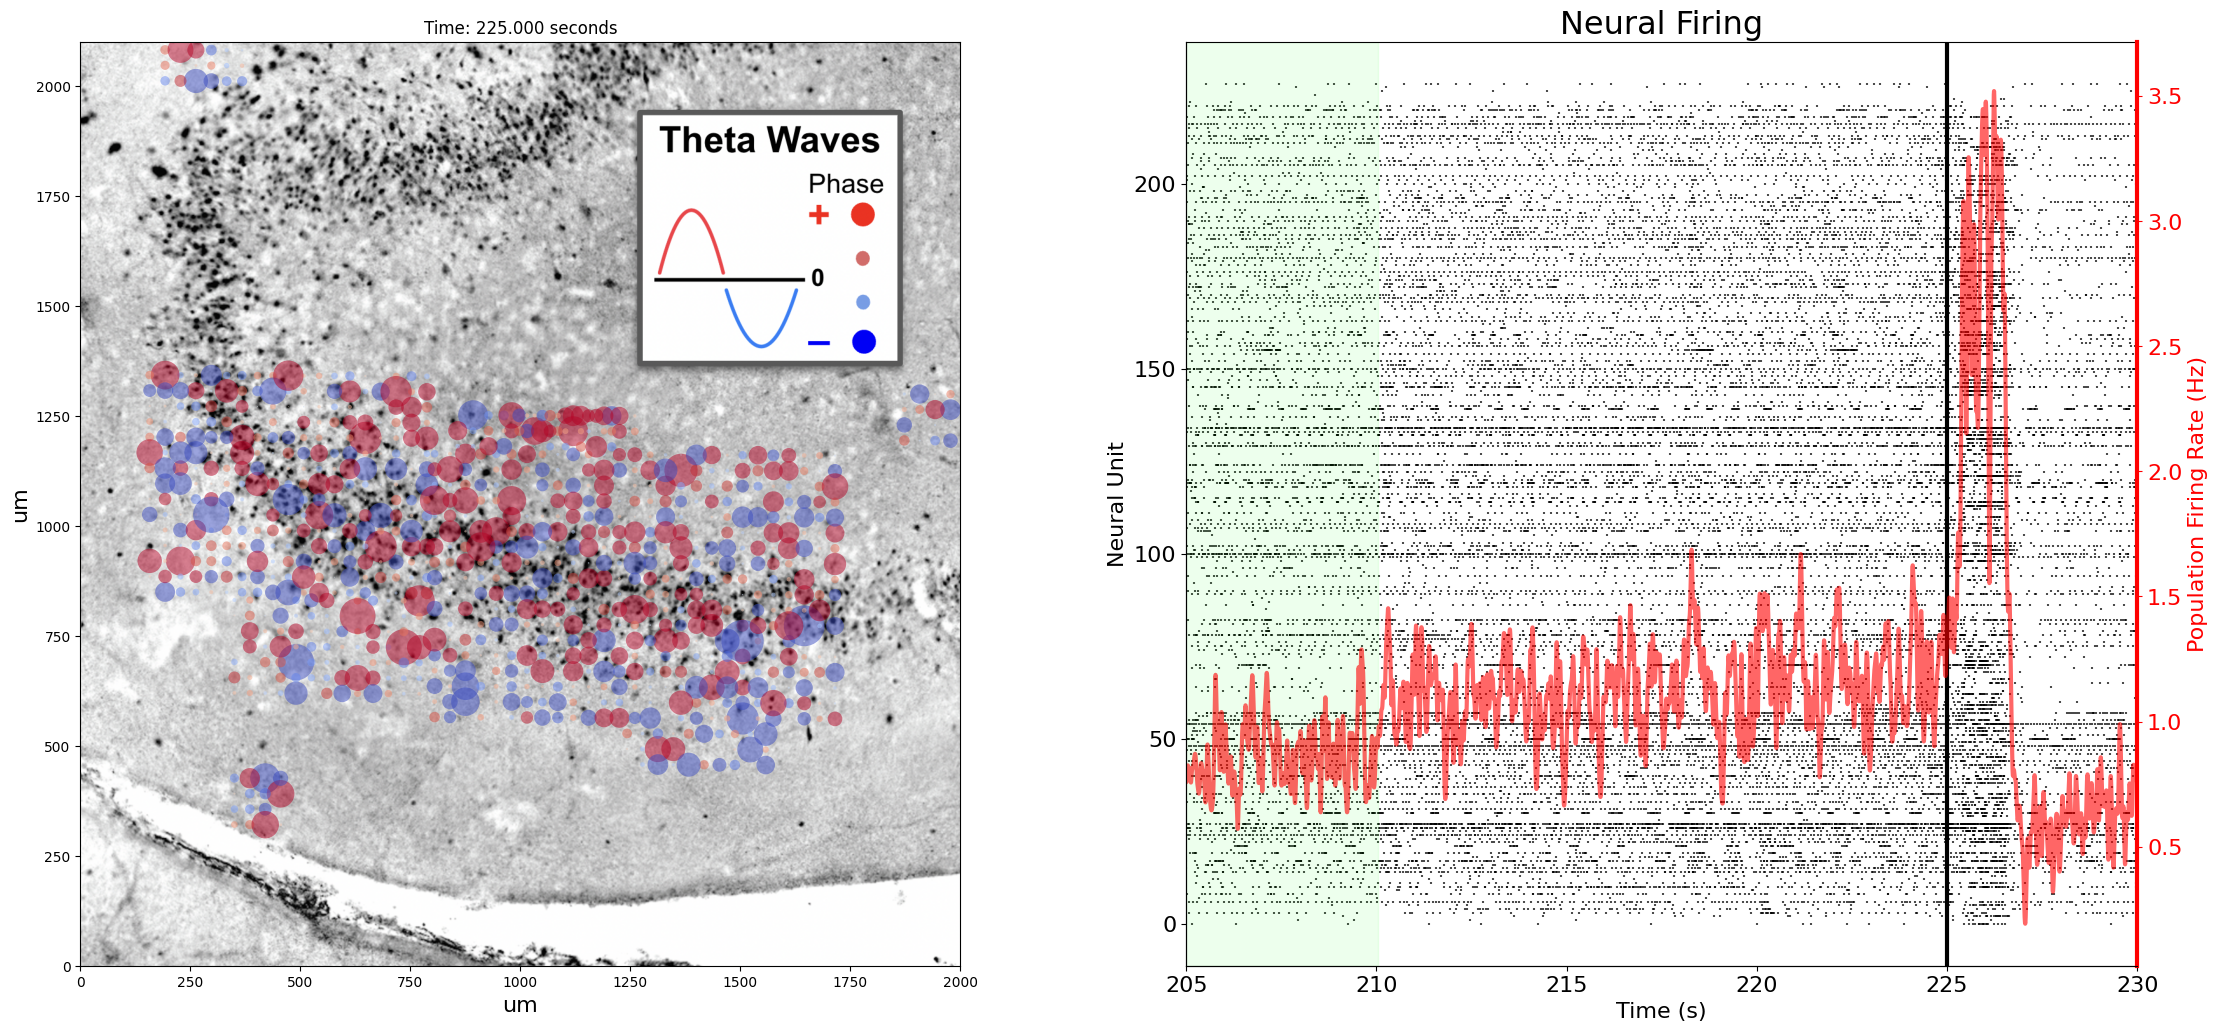

In [19]:
fig, plots = plt.subplots(nrows=1,ncols=2,figsize=(27,12))

### Code for Theta Plot ###
data = get_brain_waves( raw_dict["data"], raw_dict["frame_rate"] )[wave_type]  # get common brain waves
norm = plt.Normalize( vmin= np.mean(data)-np.std(data), vmax= np.mean(data)+np.std(data) )
img = plt.imread(image_path)      # Load in image
plots[0].imshow(img,  extent=[0, 3850, 0, 2100]) # Plot image, have it correspond to electrode dimensions
plot0 = plots[0].scatter( raw_dict['xy'][:,1], raw_dict['xy'][:,0]/-12.5+2100, c=data[:,0] , norm=norm, cmap=cm.coolwarm,
                        s=(np.abs(data[:,0])**size_exp)*size_scale ,  alpha=.5 , edgecolor='none' )
plots[0].set_xlim(0,2000)
plots[0].set_xlabel('um', fontsize=16)                                         # add axises and title
plots[0].set_ylabel('um', fontsize=16)

### Code for Raster ###
# Get firing rate
pop_rate = sd.binned(bin_size=1)
pop_fr = gaussian_filter1d(pop_rate.astype(float), sigma=20)
bins = np.linspace(0, sd.length, pop_rate.shape[0] ) #/1000
plots[1].set_title("Neural Firing", fontsize=23)
y = 0
for vv in sd.train:
    plots[1].scatter(vv/1000, [y]*len(vv), marker="|", c='k', s=4, alpha=0.7)
    y += 1
plots[1].set_xlabel("Time (s)", fontsize=16)
plots[1].set_ylabel("Neural Unit", fontsize=16)
plots[1].xaxis.set_tick_params(labelsize=16)
plots[1].yaxis.set_tick_params(labelsize=16)
plots[1].axvspan( opto[-1,0], opto[-1,1], color='#00FF00', alpha=0.1) # color='green'

for row in opto:
    plots[1].axvspan(row[0], row[1], color='#00FF00', alpha=0.07) # color='green'

axs1 = plots[1].twinx()
axs1.yaxis.set_label_position("right") 
axs1.spines['right'].set_color('r')
axs1.spines['right'].set_linewidth(3)
axs1.plot(bins/1000, pop_fr, color='r', linewidth=3, alpha=0.6)
axs1.set_ylabel("Population Firing Rate (Hz)", fontsize=16, color='r')
axs1.set_xlabel("Time (ms)", fontsize=16)
axs1.yaxis.set_tick_params(labelsize=16)
axs1.set_xlim( xlim )
#axs1.set_ylim(ylim)
axs1.spines['top'].set_visible(False)
axs1.get_xaxis().set_visible(False)
axs1.tick_params(left=False, right=True, labelleft=False, labelright=True,
                bottom=False, labelbottom=True)
axs1.tick_params(axis='y', colors='r')
vl = plots[1].axvline(x=10, color='black', linewidth=3, linestyle='-')
 

### Code for Heatmap ###


# animation function.  This is called sequentially
def animate(i):
    # Wave plot
    plot0.set_array(data[:,i])
    plot0._sizes = (np.abs(data[:,i])**size_exp)*size_scale
    plots[0].set_title(f"Time: {start_s+i/1000:.3f} seconds")
    #plots[0].set_title("")
    #plots[0].text(0.5, 1.03, "Theta waves", ha='center', va='bottom', fontsize=23, transform=plots[0].transAxes)
    #t = start_s + i / 1000
    #plots[0].text(0.5, 1.024, f"{start_s+i/1000:.3f} seconds", ha='center', va='top', fontsize=17, transform=plots[0].transAxes)

    # Raster Plot
    t = start_s + i/1000
    vl.set_xdata([t,t])
    return plots

anim = FuncAnimation(fig, animate, frames=movie_range_ms, interval=100, blit=False)  
anim.save( filename )